In [107]:
import pandas as pd
import numpy as np
import random as rnd
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

In [109]:
import mlrose_hiive

In [110]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, 
                        cv=None, scoring='accuracy', n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring=scoring,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

    return plt

In [111]:
SEED = 1

In [112]:
features = 'REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT, SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN'
col_names = features.split(',') + ['Class']
# print(col_names)

In [113]:
dataset_dir = '../Datasets/statlog_image_segmentation'
df = pd.read_csv(dataset_dir + '/segment.dat', names=col_names, sep=' ')
df.shape

(2310, 20)

In [114]:
df.head(2)

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN,Class
0,218.0,178.0,9,0.111111,0.0,0.833333,0.547722,1.111109,0.544331,59.629630,52.444443,75.222220,51.222220,-21.555555,46.77778,-25.222221,75.222220,0.318996,-2.040554,6
1,113.0,130.0,9,0.000000,0.0,0.277778,0.250924,0.333333,0.365148,0.888889,0.000000,2.555556,0.111111,-2.666667,5.00000,-2.333333,2.555556,1.000000,-2.123254,3


In [115]:
column_names = df.columns
y = df['Class'].copy().values
X = df.drop(['Class'], axis=1).values

In [116]:
# Normalize feature data
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [117]:
# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.fit_transform(y_test.reshape(-1, 1)).todense()

# Gradient Descent (gd)

In [25]:
# Initialize neural network object and fit object
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes=[30, 20], activation='relu',
                                   algorithm='gradient_descent',                                        
                                   bias=True, is_classifier=True,                                        
                                   early_stopping=True, clip_max=5,
                                   learning_rate=0.0001,
                                   max_iters=2000,
                                   max_attempts=100,
                                   random_state=SEED)


In [40]:
## Fit Gradient Descent
nn_gd.fit(X_train_scaled, y_train_hot)

NeuralNetwork(activation='relu', algorithm='gradient_descent', bias=True,
              clip_max=5, curve=False, early_stopping=True,
              hidden_nodes=[30, 20], is_classifier=True, learning_rate=0.0001,
              max_attempts=100, max_iters=2000, mutation_prob=0.1, pop_size=200,
              random_state=1, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [53]:
# Predict labels for train set and assess accuracy
y_train_pred_hot = nn_gd.predict(X_train_scaled)
y_train_pred = one_hot.inverse_transform(y_train_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_train, y_train_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_train, y_train_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_train, y_train_pred, average='macro')
print('F1', f1)

roc = roc_auc_score(y_train, y_train_pred, multi_class='ovr')
print(roc)



CM:
 [[270   0   0   0   3   0   0]
 [  0 253   0   0   0   0   0]
 [  0   0 233   5  17   0   0]
 [  0   0   0 265  12   0   0]
 [  1   0  12   7 247   0   0]
 [  0   0   0   0   0 257   0]
 [  0   0   0   0   0   0 266]]
ACC 0.9691558441558441
F1 0.9694410948494923


AxisError: axis 1 is out of bounds for array of dimension 1

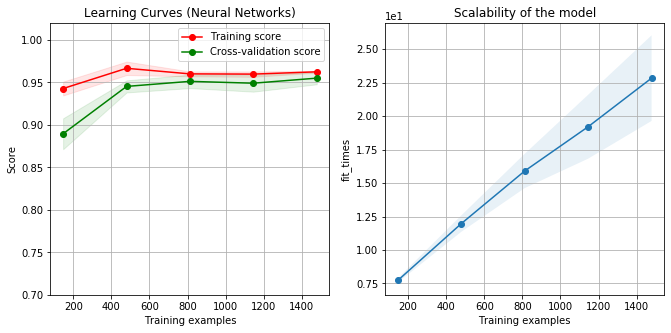

In [39]:
## plot learning curve
# nn_clf = MLPClassifier(hidden_layer_sizes=(30,20), random_state=0,
#                        activation='relu', solver='lbfgs', alpha=30, 
#                        max_iter=2000)

# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cv = 5

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
title = r"Learning Curves (Neural Networks)"

plot_learning_curve(nn_gd, title, X_train_scaled, y_train_hot, axes=axes, ylim=(0.7, 1.02),
                    cv=cv, scoring='accuracy', n_jobs=-1)

plt.show()

In [88]:
hidden_nodes=[30, 20]
# Initialize neural network object and fit object
nn_model = mlrose_hiive.NeuralNetwork(hidden_nodes=hidden_nodes, activation='relu',
                                      algorithm='genetic_alg',
                                      pop_size = 200,
                                      mutation_prob = 0.25,
                                      bias=True, is_classifier=True,
                                      early_stopping=True, clip_max=5,
                                      random_state=1,
                                      max_iters=1000,
                                      learning_rate=0.0001,
                                      max_attempts=100)

In [89]:
## Fit Gradient Descent
nn_model.fit(X_train_scaled, y_train_hot)

NeuralNetwork(activation='relu', algorithm='genetic_alg', bias=True, clip_max=5,
              curve=False, early_stopping=True, hidden_nodes=[30, 20],
              is_classifier=True, learning_rate=0.0001, max_attempts=100,
              max_iters=1000, mutation_prob=0.25, pop_size=200, random_state=1,
              restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [91]:
# Predict labels for train set and assess accuracy
y_train_pred_hot = nn_model.predict(X_train_scaled)
y_train_pred = one_hot.inverse_transform(y_train_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_train, y_train_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_train, y_train_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_train, y_train_pred, average='macro')
print('F1', f1)

# roc = roc_auc_score(y_train, y_train_pred, multi_class='ovr')
# print(roc)



CM:
 [[  0  43   1   0 219  10   0]
 [  0 244   0   0   0   0   9]
 [  0  25 101   0 121   0   8]
 [  0 140  12   0  28  53  44]
 [  0  28  11   0 144   0  84]
 [  0   8  31   0  35 134  49]
 [  0   0   1   0  17   0 248]]
ACC 0.4713203463203463
F1 0.39804350024543783


In [8]:
import numpy as np
from sklearn.datasets import load_iris

# Load the Iris dataset
data = load_iris()

# Get feature values
print(data.data[0])
# [ 5.1  3.5  1.4  0.2]

# Get feature names
print(data.feature_names)
# ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

# Get target value of first observation
print(data.target[0])
# 0

# Get target name of first observation
print(data.target_names[data.target[0]])
# setosa

# Get minimum feature values
print(np.min(data.data, axis = 0))
# [ 4.3  2.   1.   0.1]

# Get maximum feature values
print(np.max(data.data, axis = 0))
# [ 7.9  4.4  6.9  2.5]

# Get unique target values
print(np.unique(data.target))
# [0 1 2]

[5.1 3.5 1.4 0.2]
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
0
setosa
[4.3 2.  1.  0.1]
[7.9 4.4 6.9 2.5]
[0 1 2]


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, \
                                                    test_size = 0.2, random_state = 3)

# Normalize feature data
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()


In [6]:
import mlrose_hiive
# Initialize neural network object and fit object
nn_model1 = mlrose_hiive.NeuralNetwork(hidden_nodes = [2], activation = 'relu', \
                                 algorithm = 'random_hill_climb', max_iters = 1000, \
                                 bias = True, is_classifier = True, learning_rate = 0.0001, \
                                 early_stopping = True, clip_max = 5, max_attempts = 100, \
                                 random_state = 3)

# nn_model1.fit(X_train_scaled, y_train_hot)

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

In [7]:
np.logspace(0, 4, 20).astype(int) * 2

array([    2,     2,     4,     8,    12,    22,    36,    58,    96,
         156,   254,   412,   670,  1090,  1770,  2876,  4670,  7584,
       12316, 20000])

In [10]:
# x_train = data_dict['xtrain']
# y_train = data_dict['ytrain']
# x_test = data_dict['xtest']
# y_test = data_dict['ytest']
iterations = [100,500,1000]
params = [{'max_iters': iterations, 'restarts': [20,50,100]} ]
clf = GridSearchCV(nn_model1, params, cv=3, scoring='accuracy', n_jobs=3, verbose=3, refit=True)


In [11]:
clf.fit(X_train_scaled, y_train_hot)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed:  4.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=NeuralNetwork(activation='relu',
                                     algorithm='random_hill_climb', bias=True,
                                     clip_max=5, curve=False,
                                     early_stopping=True, hidden_nodes=[2],
                                     is_classifier=True, learning_rate=0.0001,
                                     max_attempts=100, max_iters=1000,
                                     mutation_prob=0.1, pop_size=200,
                                     random_state=3, restarts=0,
                                     schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)),
             iid='deprecated', n_jobs=3,
             param_grid=[{'max_iters': [100, 500, 1000],
                          'restarts': [20, 50, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [12]:
print(clf.best_params_)

{'max_iters': 100, 'restarts': 20}


In [13]:
print(clf.score(X_train_scaled, y_train_hot))

0.4583333333333333


In [16]:
y_pred_hot = clf.predict(X_train_scaled)

acc_nn = accuracy_score(y_train_hot, y_pred_hot)  # Accuracy Score
print (acc_nn)


0.4583333333333333


In [19]:
y_pred = one_hot.inverse_transform(y_pred_hot)

acc = accuracy_score(y_train, y_pred)
print(acc)

cm = confusion_matrix(y_train, y_pred)  # Confusion Matrix
print(cm)

0.4583333333333333
[[15 25  0]
 [ 0 40  0]
 [ 0 40  0]]


In [16]:
from sklearn.metrics import accuracy_score

# Predict labels for train set and assess accuracy
y_train_pred = nn_model1.predict(X_train_scaled)

y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)

In [17]:
print(y_train_accuracy)
# 0.45

# Predict labels for test set and assess accuracy
y_test_pred = nn_model1.predict(X_test_scaled)

y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)

print(y_test_accuracy)
# 0.533333333333

0.45
0.5333333333333333


In [ ]:
samodel = mlrose.NeuralNetwork(hidden_nodes = [3*n_features//2],
                                activation ='sigmoid', 
                                algorithm ='simulated_annealing', 
                                max_iters = 4000, bias = False, is_classifier = True, 
                                lr=0.0001, early_stopping = True, schedule=mlrose.GeomDecay(15., .99, .1),
                                clip_max=5, max_attempts = 25)

In [9]:
a = np.arange(6).reshape((3, 2))
a

array([[0, 1],
       [2, 3],
       [4, 5]])

In [12]:
one_hot.fit_transform(a.reshape(-1,1)).todense()

matrix([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])

In [83]:
# file = './output/nn_sa/nngs_sa__nn_sa__run_stats_df__E6DF49B9C120149562B307354E3BE70A.csv.del'


In [130]:
df_run_stats = pd.read_csv(file)

FileNotFoundError: [Errno 2] File b'./output/nn_sa/nngs_sa__nn_sa__run_stats_df__E6DF49B9C120149562B307354E3BE70A.csv.del' does not exist: b'./output/nn_sa/nngs_sa__nn_sa__run_stats_df__E6DF49B9C120149562B307354E3BE70A.csv.del'

In [131]:
df_run_stats.head()

,Unnamed: 0,Iteration,Fitness,Time,State,schedule_type,schedule_init_temp,schedule_exp_const,schedule_min_temp,schedule_current_value,...,schedule,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
0,0,0,5.191381,0.003983,"[-0.165955990594852, 0.4406489868843162, -0.99...",exponential,1.0,0.005,0.001,0.999980,...,1.0,"[-0.165955990594852, 0.4406489868843162, -0.99...",sa,relu,True,False,1.000000e+10,"[30, 20]",0.1,20
1,1,100,5.243628,0.149281,"[-0.165955990594852, 0.4406489868843162, -0.99...",exponential,1.0,0.005,0.001,0.999254,...,1.0,"[-0.165955990594852, 0.4406489868843162, -0.99...",sa,relu,True,False,1.000000e+10,"[30, 20]",0.1,20


In [132]:
import pickle

In [133]:
fname = './output/nn/nngs_ga__nn__grid_search_results__6835FB69FB8BF786B6F2ECFE1428B431.p.del'
with open(fname, "rb") as f:
    sr = pickle.load(f)

In [134]:
sr.best_estimator_

NNClassifier(activation=<function relu at 0x7f644804cdd0>,
             algorithm=<function genetic_alg at 0x7f64480c5050>, bias=True,
             clip_max=5, early_stopping=True, hidden_layer_sizes=[100],
             learning_rate=0.01, learning_rate_init=0.1, max_attempts=500,
             max_iters=100, mutation_prob=0.25, pop_size=500,
             runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x7f642ec15f50>,
             schedule=ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001),
             seed=1)

In [135]:
sr.best_score_

0.45826091824056014

In [136]:
y_train_pred_hot = sr.best_estimator_.predict(X_train_scaled)
# score = sr.score(y_train_pred_hot, y_train_hot)
# print(score)

In [137]:
# Predict labels for train set and assess accuracy
# y_train_pred_hot = nn_model.predict(X_train_scaled)
y_train_pred = one_hot.inverse_transform(y_train_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_train, y_train_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_train, y_train_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_train, y_train_pred, average='macro')
print('F1', f1)

# roc = roc_auc_score(y_train, y_train_pred, multi_class='ovr')
# print(roc)



CM:
 [[  0   0   0 131 122  20   0]
 [  0 191   0   0   0  62   0]
 [  0   0   0   8 223  24   0]
 [  0   0   0  11  28 238   0]
 [  0   0   0  28 202  37   0]
 [  0  30   0  17   0 210   0]
 [  0   0   0   0 187   3  76]]
ACC 0.37337662337662336
F1 0.31187328439149314
